# CLUSTER INDEPENDENT ANNOTATION

In [1]:
library(devtools)
document()

Loading required package: usethis

ℹ Updating CIA documentation
ℹ Loading CIA
Warning message:
“replacing previous import ‘Seurat::components’ by ‘igraph::components’ when loading ‘CIA’”
Warning message:
“replacing previous import ‘igraph::crossing’ by ‘tidyr::crossing’ when loading ‘CIA’”


In [2]:
library(Seurat)
library(data.table)
library(future)
library(future.apply)
library(Matrix)
library(sparseMatrixStats)
library(SingleCellExperiment)
library(clusterExperiment)
library(igraph)
library(CIA)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘Seurat’


The following object is masked from ‘package:CIA’:

    components



Attaching package: ‘data.table’


The following object is masked from ‘package:CIA’:

    melt



Attaching package: ‘future’


The following objects are masked from ‘package:CIA’:

    %->%, %<-%



Attaching package: ‘Matrix’


The following objects are masked from ‘package:CIA’:

    expand, pack, unpack


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:CIA’:

    colSums2


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians



Attaching package: ‘MatrixGenerics’


The following object

## Index

1. [Introduction](#introduction)
2. [CIA input](#CIA-input)
   - [Gene signatures](#Gene-signatures)
   - [Data input](#Data-input)
3. [Signature score](#Signature-score)
   - [Default score](#Default-score)
   - [Scaled score](#Scaled-score)
4. [Signature-based classification](#Signature-based-classification)
   - [Default classification](#Default-classification)
   - [Classification with similarity threshold](#Classification-with-similarity-threshold)
5. [Classification performance evaluation](#Classification-performance-evaluation)
6. [Tips](#Tips)
   - [Direct inspection of MSigDB signatures](#Direct-inspection-of-MSigDB-signatures)
   - [Majority voting](#Majority-voting)
   - [Extraction of signatures from Differentially Expressed Genes](#Extraction-of-signatures-from-DEGs)
   - [Alternative representation of cell group composition](#Alternative-representation-of-cell-group-composition)
7. [Conclusion](#Conclusion)
8. [References](#References)

## Introduction

**Cluster Independent Annotation** (**CIA**) is a classification method designed to **assist researchers during the cell annotation step** of scRNA-seq experiments. Given gene signatures as input, this classifier **computes a signature score for each cell** and **compares the score values** to assign a label to each single cell. 

This tool offers several advantages:

-	It synthesizes the information of **an entire signature expression into a single score value**, avoiding the tedious inspection of individual marker genes from lengthy differentially expressed genes (DEGs) lists, which may not be cluster-specific individually.
-   It makes possible the exploration of new signatures derived from your research for which training data for machine learning algorithms may not yet exist.
-	It provides a classification for each cell that is **completely independent of clustering**, allowing it to be used alongside a clustering method to set a proper resolution value, thus yielding coherent and easily annotated cell groups.

-	**It's very fast**: it can classify a large dataset (hundreds of thousands of cells) in just a few seconds since **we have implemented the ability to parallelize processes**.

-	Being signature-based, this tool can deliver insights on **any kind of biologically meaningful gene list**, also enabling functional annotation. 

-	By normalizing for the gene signature length, it facilitates the **comparison of gene sets of varying lengths**, ranging **from tens to thousands of genes**.


## CIA input

Our method requires as input a **named list of gene signatures** (e.g. cell type, cell state ...) and a scRNA-seq data in **[SeuratObject](https://rdrr.io/cran/SeuratObject/) or [SingleCellExperiment](https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html) format**.

### Gene signatures

In our study, we used the differentially expressed genes (DEGs) from Hao et al., 2021's [[1]](https://www.sciencedirect.com/science/article/pii/S0092867421005833) **PBMC atlas** as signature markers. The original clusters in this dataset were annotated using an integrated analysis combining RNA and protein data, ensuring the **RNA-based gene lists accurately represent specific cell types**. We focused on the broadest annotation level for clearer visualization and easier cross-dataset comparison.
**We omitted the 'other T'** label from our analysis, as it includes cell types not present in the PBMC3K dataset, making validation impossible. The **'other'** cluster, predominantly platelets, **was relabeled as 'Platelet'** for clarity.

N.B. - DEGs have been filtered to create concise and targeted gene lists: a log2 fold change greater than 1.5, a minimum average expression level of 0.25, a z-score above 5, and expression in at least 40% of the cells within each cluster.

In [3]:
# to load the gene signatures
gmt<-load_signatures('../inst/extdata/atlas.gmt')
#load_signatures can load both dictionaries or gmt files by providing both file_paths or URLs

for (i in  names(gmt)){
    cat(paste0(i, ':'), length(gmt[[i]]), 'genes \n')
}



B: 115 genes 
CD4 T: 43 genes 
CD8 T: 22 genes 
DC: 156 genes 
Mono: 674 genes 
NK: 130 genes 
Platelet: 132 genes 


In [4]:
# to check gene lists similarity (Jaccard Index)
signatures_similarity(gmt, metric_name = 'jaccard')

,B,CD4 T,CD8 T,DC,Mono,NK,Platelet
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B,1.000000000,0.006369427,0.000000000,0.097165992,0.01937984,0.004098361,0.008163265
CD4 T,0.006369427,1.000000000,0.203703704,0.000000000,0.00000000,0.000000000,0.000000000
CD8 T,0.000000000,0.203703704,1.000000000,0.000000000,0.00000000,0.034013605,0.006535948
DC,0.097165992,0.000000000,0.000000000,1.000000000,0.08072917,0.007042254,0.014084507
Mono,0.019379845,0.000000000,0.000000000,0.080729167,1.00000000,0.005000000,0.028061224
NK,0.004098361,0.000000000,0.034013605,0.007042254,0.00500000,1.000000000,0.023437500
Platelet,0.008163265,0.000000000,0.006535948,0.014084507,0.02806122,0.023437500,1.000000000


### Data input

In order **to evaluate both the consistency** of our method **and the performances of classification**, **we used** the PMBC atlas **DEGs to automatically annotate** the [PBMC3K](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html) dataset from *Satija et al., 2015* [[2]](https://www.nature.com/articles/nbt.3192). This dataset was annotated by the authors relying on clustering and marker genes expression inspection and it is widely used as reference in the scientific community.
**We classified** this dataset **independently from the already present annotation**, whose **cell labels were used as ground truth** to evaluate our classification perfomances with different modalities.

Our method support both SeuratObject (SO) an SingleCellExperiment (SCE) and it is tested on expression data previously scaled to 10000 and Log-normalized, for this reason we strongly suggest to normalize your count matrix as follows:

#### SeuratObject

In [5]:
SO <- readRDS('../inst/extdata/pbmc3k.rds')
SO<- NormalizeData(SO, normalization.method = "LogNormalize", scale.factor = 10000) # to add "data" layer
SO

An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features, 2000 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: pca, umap

#### SingleCellExperiment

In [6]:
SCE <- as.SingleCellExperiment(readRDS('../inst/extdata/pbmc3k.rds'),)
library_sizes <- colSums(assay(SCE, 'counts'))
normalized_counts <- sweep(assay(SCE, 'counts'), 2, library_sizes, FUN = "/") * 10000
assay(SCE, 'logcounts') <- log1p(normalized_counts) # to add 'logcounts' assay
SCE

class: SingleCellExperiment 
dim: 13714 2638 
metadata(0):
assays(2): counts logcounts
rownames(13714): AL627309.1 AP006222.2 ... PNRC2.1 SRSF10.1
rowData names(0):
colnames(2638): AAACATACAACCAC AAACATTGAGCTAC ... TTTGCATGAGAGGC
  TTTGCATGCCTCAC
colData names(9): orig.ident nCount_RNA ... celltype ident
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

In [7]:
SCE@metadata$graphs[['RNA_snn']]<- SO@graphs$RNA_snn

For the classification of the test dataset **we renamed and merged some clusters** in order to make easier the comparison and the visualization of results.
In particular, ‘CD14+ Monocytes' and 'FCGR3A+ Monocytes' clusters were merged into ‘Mono’. 

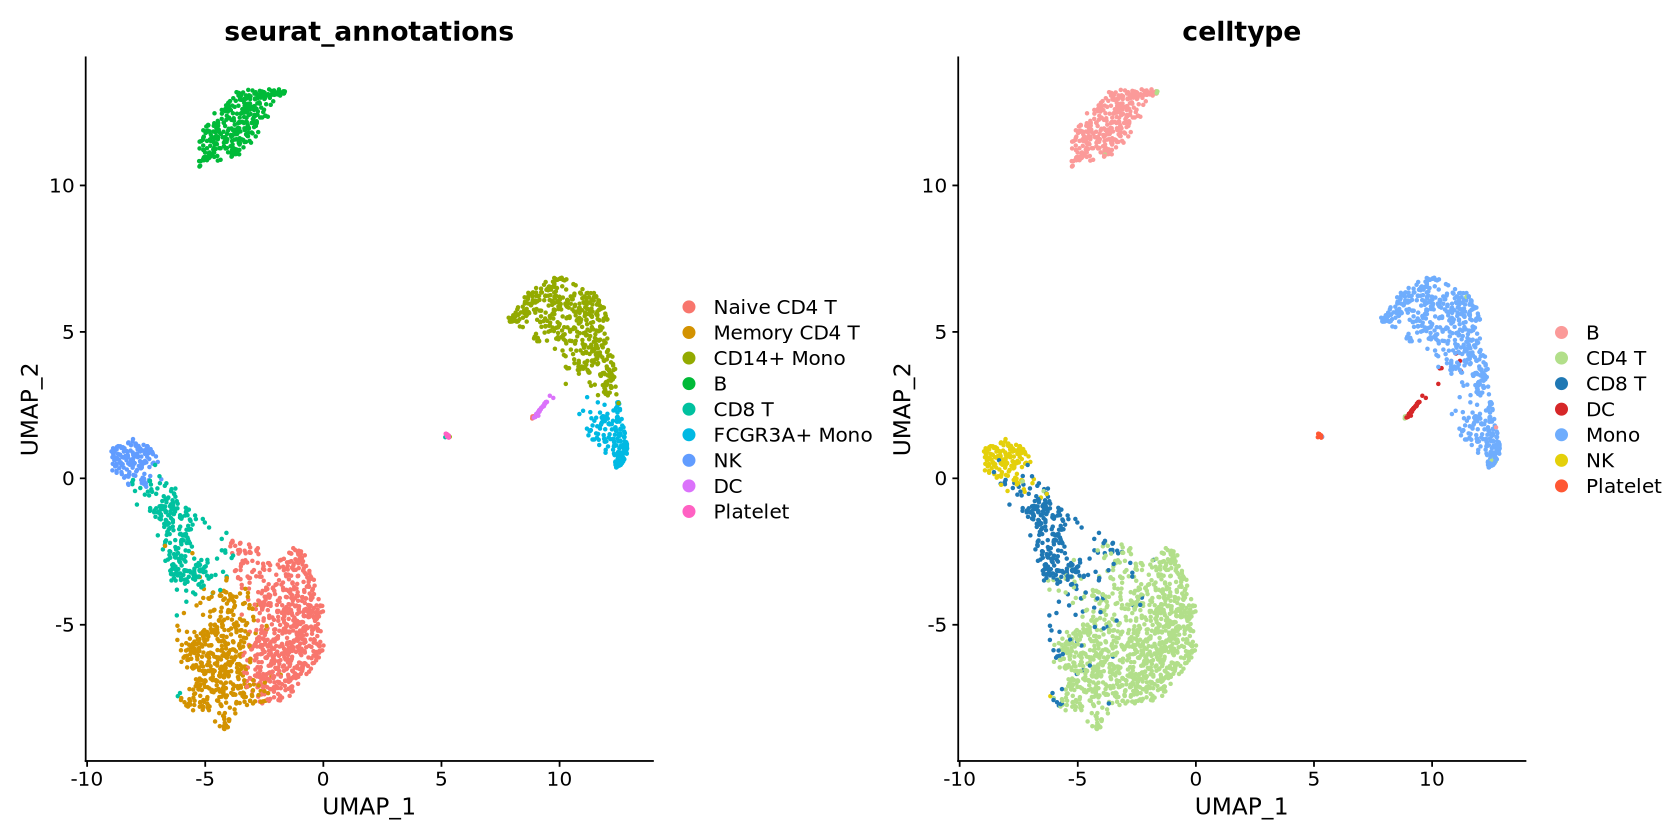

In [8]:
options(repr.plot.width=14, repr.plot.height=7)
DimPlot(SO, group.by = 'seurat_annotations')|DimPlot(SO, group.by = 'celltype' , 
                                                    cols = c('#fb9a99','#b2df8a', '#1f78b4',
                                                             '#d62728', '#6fadfd','#E4D00A','#FF5733'))

## Signature score

The `score_signature` function is **based on the "gene signature score"** calculation method presented in *Della Chiara, Gervasoni, Fakiola, Godano et al., 2021* [[3]](https://www.nature.com/articles/s41467-021-22544-y). The "gene signature score" of a signature **S** in a cell **C** is defined as follows:

$${\bf{GSS(C)}}=\frac{n}{L}\frac{\sum_{i=1}^n {\bf{X}}_i\: for\: {\bf{G}}_i \in S}{\sum_{j=1}^m {\bf{X}}_j\: for\: {\bf{G}}_j \in G}$$

Where:
- **n** is the number of genes in **S** that are expressed in **C**;
- **G** = {𝐺₁, 𝐺₂, …, 𝐺ₘ} is the list of length **m** that contains all the gene symbols of cell **C**;
- **S** = {𝐺₁, 𝐺₂, …, 𝐺ₗ} is the list of gene symbols of length **L** that compose the signature;
- **X** = {𝑋₁, 𝑋₂, …, 𝑋ₘ} is the vector of gene expression values for genes in list **G**.

With this score it is possible to **condensate in a single value both the proportion of expressed signature genes and their overall expression**, enabling researchers to easily study whole signatures expression at single cell level. 

Here we show how to compute the scores of a gene signature for both a SeuratObject and a SingleCellExperiment:

In [9]:
head(score_signature(data=SO, geneset=gmt[['B']]))
# compute the signature scores of B cells gene signature for each cell

AAACATACAACCAC AAACATTGAGCTAC AAACATTGATCAGC AAACCGTGCTTCCG AAACCGTGTATGCG 
    0.16288457     2.03657305     0.05562652     0.30427311     0.04584919 
AAACGCACTGGTAC 
    0.17252396

In [10]:
head(score_signature(data=SCE, geneset=gmt[['B']]))
# compute the signature scores of B cells gene signature for each cell

AAACATACAACCAC AAACATTGAGCTAC AAACATTGATCAGC AAACCGTGCTTCCG AAACCGTGTATGCG 
    0.16288457     2.03657305     0.05562652     0.30427311     0.04584919 
AAACGCACTGGTAC 
    0.17252396

### Default score

To compute the signature scores of each signature in parallel, we implemented the `score_all_signatures` function.
The function calls `load_signatures`, allowing it to support both **named lists** and canonical **gmt files** (tab separated and without header), which can be provided as either a **filepath** or a **URL**.

For **SeuratObjects**, it is possible to select the matrix on which to compute the scores by setting the `seurat_assay` and `seurat_layer` parameters. By default, these are set to `RNA` and `data`, respectively.


In [11]:
SO<- score_all_signatures(SO,signatures_input = '../inst/extdata/atlas.gmt',
                          seurat_assay = 'RNA', seurat_layer = 'data', n_cpus = 32)

Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132

Scores have been added in data@meta.data




In [12]:
head(SO@meta.data[, names(gmt)])

,B,CD4 T,CD8 T,DC,Mono,NK,Platelet
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACATACAACCAC,0.16288457,0.212983929,0.133218159,0.10187131,3.586130,0.7955111,0.2898321
AAACATTGAGCTAC,2.03657305,0.040764675,0.009784282,0.98941011,9.018180,0.4460580,0.7280882
AAACATTGATCAGC,0.05562652,0.423940323,0.058273797,0.09394621,5.277053,0.4472809,0.5555454
AAACCGTGCTTCCG,0.30427311,0.003292528,0.003292528,0.96080890,28.666898,0.3975832,0.7439242
AAACCGTGTATGCG,0.04584919,0.015666095,0.064993873,0.31236608,1.749118,3.6227560,0.3055454
AAACGCACTGGTAC,0.17252396,0.266174648,0.022475070,0.31425079,4.557137,0.2920672,0.5572601


For **SingleCellExperiment** objects, the same can be done by setting the `sce_assay` parameter, which is set to `logcounts` by default.

In [13]:
SCE<- score_all_signatures(SCE,signatures_input = '../inst/extdata/atlas.gmt',sce_assay = 'logcounts', n_cpus = 32)

Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132

Scores have been added in colData(data)




In [14]:
head(colData(SCE)[, names(gmt)])

DataFrame with 6 rows and 7 columns
                       B      CD4 T      CD8 T        DC      Mono        NK
               <numeric>  <numeric>  <numeric> <numeric> <numeric> <numeric>
AAACATACAACCAC 0.1628846 0.21298393 0.13321816 0.1018713   3.58613  0.795511
AAACATTGAGCTAC 2.0365731 0.04076468 0.00978428 0.9894101   9.01818  0.446058
AAACATTGATCAGC 0.0556265 0.42394032 0.05827380 0.0939462   5.27705  0.447281
AAACCGTGCTTCCG 0.3042731 0.00329253 0.00329253 0.9608089  28.66690  0.397583
AAACCGTGTATGCG 0.0458492 0.01566609 0.06499387 0.3123661   1.74912  3.622756
AAACGCACTGGTAC 0.1725240 0.26617465 0.02247507 0.3142508   4.55714  0.292067
                Platelet
               <numeric>
AAACATACAACCAC  0.289832
AAACATTGAGCTAC  0.728088
AAACATTGATCAGC  0.555545
AAACCGTGCTTCCG  0.743924
AAACCGTGTATGCG  0.305545
AAACGCACTGGTAC  0.557260

From this point in the tutorial, **we will demonstrate CIA features using data in SeuratObject format** for clarity purposes. **The following parameter settings work exactly the same for SingleCellExperiment objects**.

### Scaled score

The scaled score is the **GSS divided by the maximum score value**, an operation that rescales the values from 0 to 1. This allows scaled scores of **different signatures**, even with **varying lengths**, to be **directly compared**. To compute the 'scaled' score, score_mode must be set to 'scaled'.

In [15]:
SO<-score_all_signatures(data=SO, signatures_input= '../inst/extdata/atlas.gmt', score_mode='scaled', n_cpus=32)
head(SO@meta.data[, names(gmt)])

Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132

Scores have been added in data@meta.data




,B,CD4 T,CD8 T,DC,Mono,NK,Platelet
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACATACAACCAC,0.04612494,0.271674636,0.392244169,0.01980966,0.07163478,0.14514413,0.01256998
AAACATTGAGCTAC,0.57670789,0.051997953,0.028808591,0.19239837,0.18014278,0.08138504,0.03157709
AAACATTGATCAGC,0.01575208,0.540763019,0.171579891,0.01826856,0.10541185,0.08160816,0.02409393
AAACCGTGCTTCCG,0.08616274,0.004199831,0.009694437,0.18683664,0.57263600,0.07254063,0.03226389
AAACCGTGTATGCG,0.01298337,0.019983107,0.191366312,0.06074197,0.03493952,0.66098608,0.01325146
AAACGCACTGGTAC,0.04885458,0.339522803,0.066175025,0.06110847,0.09103114,0.05328881,0.02416830


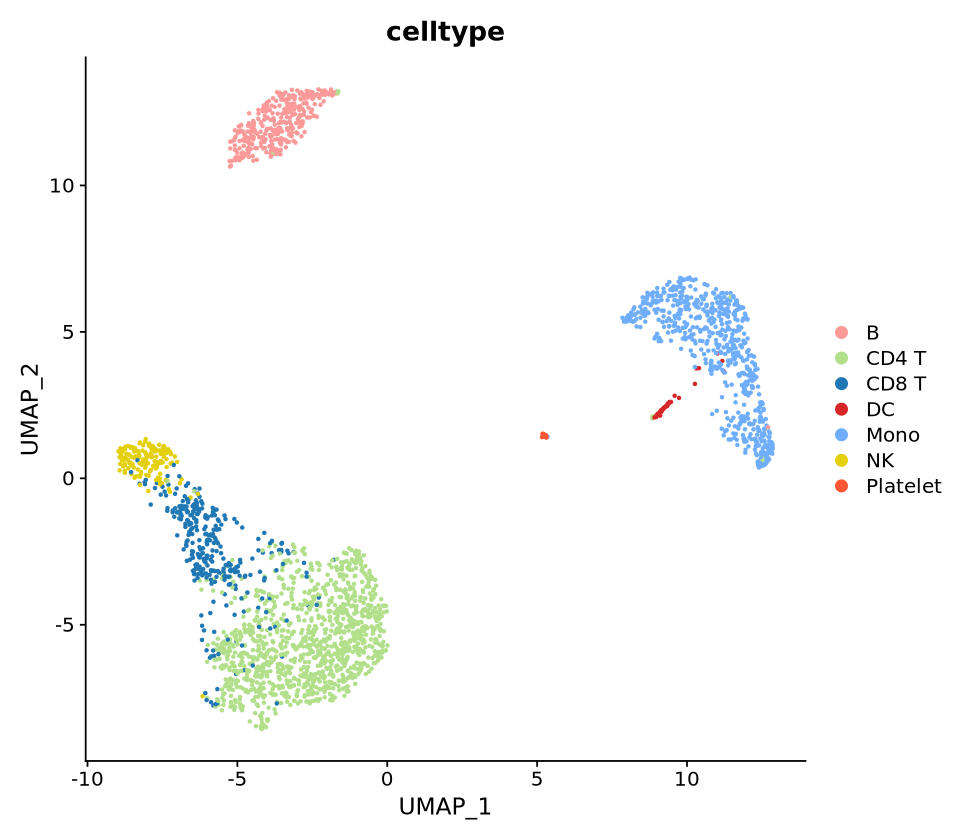

In [16]:
options(repr.plot.width=8, repr.plot.height=7)
DimPlot(SO, group.by = 'celltype' ,  cols = c('#fb9a99','#b2df8a', '#1f78b4', '#d62728', '#6fadfd','#E4D00A','#FF5733'))

By inspecting the score values, for all the signatures, **the highest values are found in the proper cluster**, indicating the sensitivity of the signatures and the capability of the signature score to represent the expression of the whole gene lists.

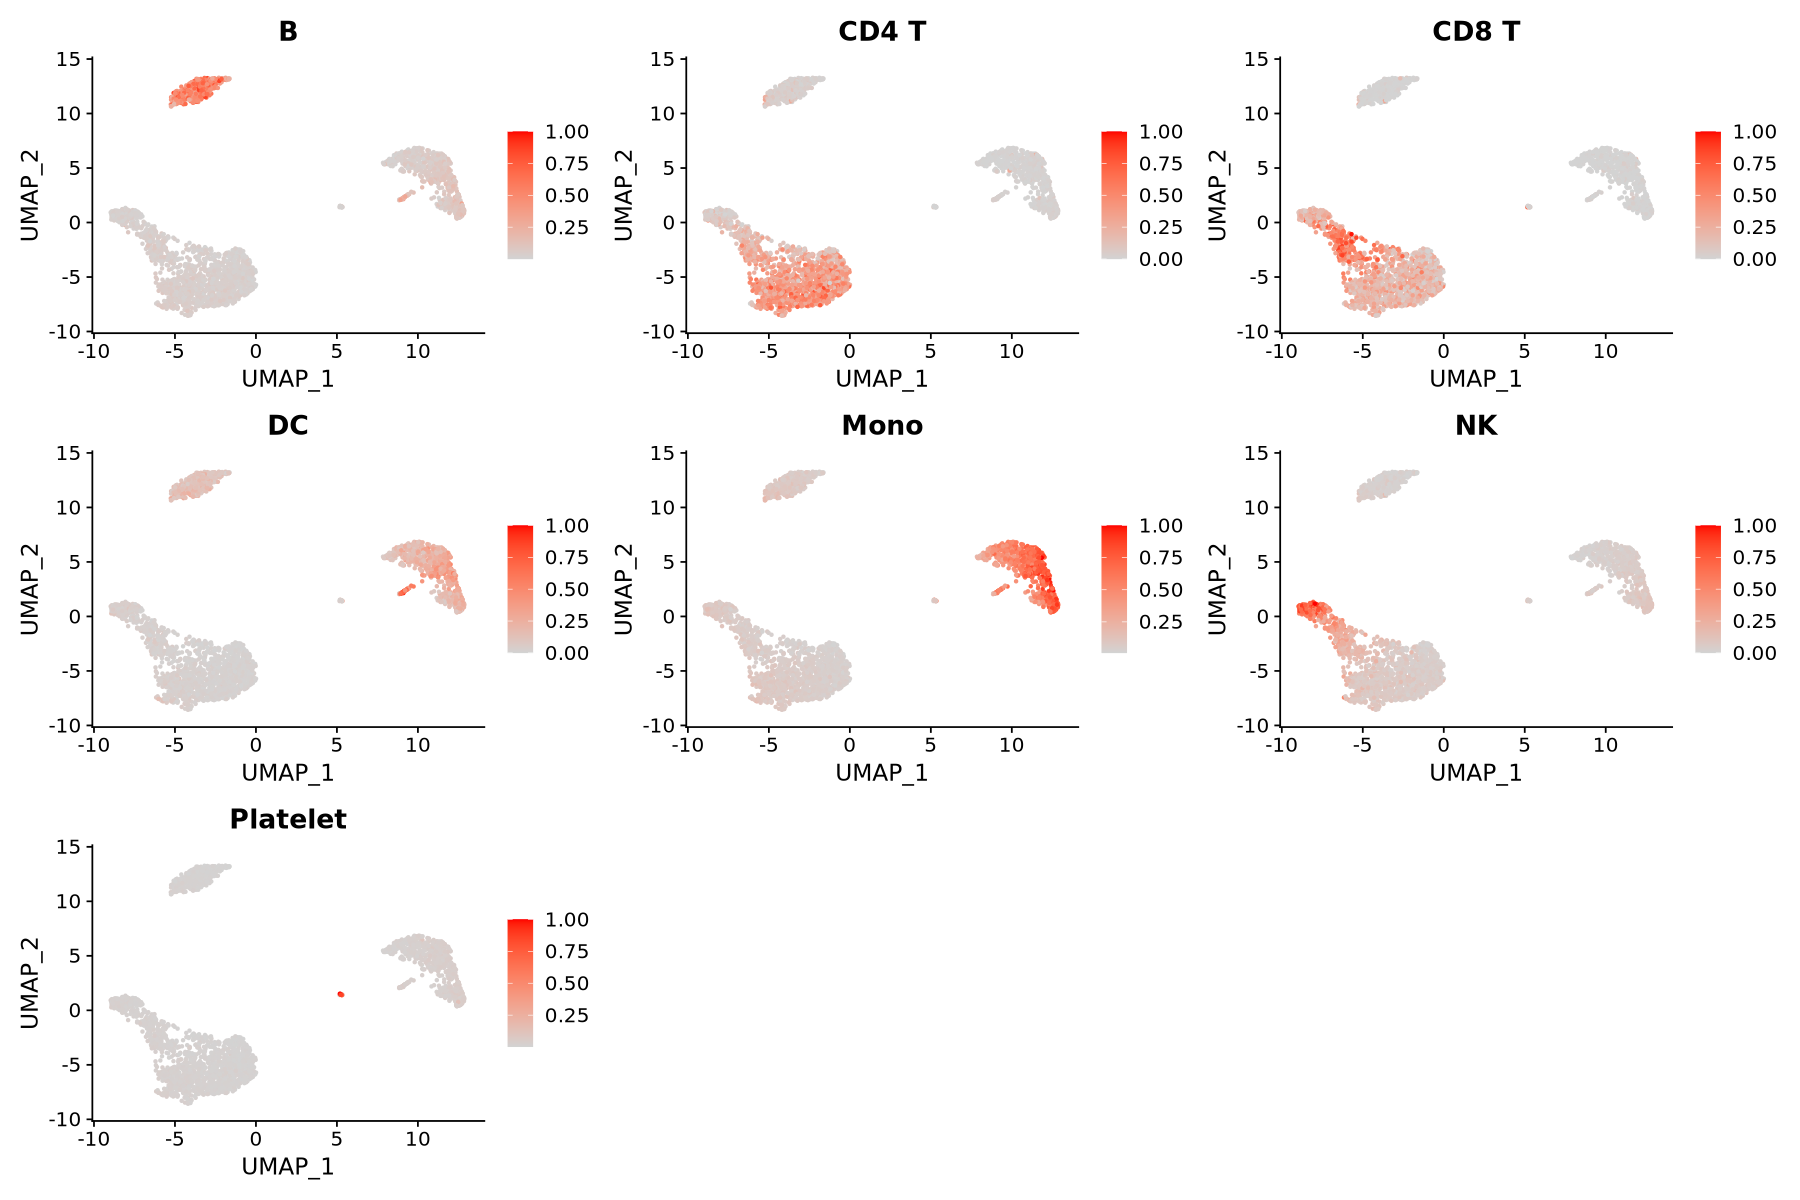

In [17]:
options(repr.plot.width=15,repr.plot.height=10)
FeaturePlot(object = SO, features = names(gmt), cols = c("lightgrey", "red"))

## Signature-based classification

To better viusualize those distributions, we exploited `grouped_distributions`. By selecting AnnData.obs columns containing **signature scores**, this function plots **a heatmap showing the medians of their values in cell groups** and it prints **a statistical report**.
**For each cell group**, a two-sided **Wilcoxon test** is perfomed to evaluate if the distribution with the highest median is different from the others. **For each signature**, a two-sided **Mann-Whitney U test** is performed to evaluate if the distribution in the cell group having the highest median is different from the other groups distributions.

[1] "Performing Wilcoxon test on each cell group ..."
[1] "WARNING in cell group DC : DC values are not significantly different from Mono values."
[1] "(p= 0.0158787611871958 )"
[1] "Performing Mann-Whitney U test on each selected AnnData.obs column ..."
[1] "For each distribution, there is only a cell group in which values are higher with respect to all the other groups (p<0.01)"


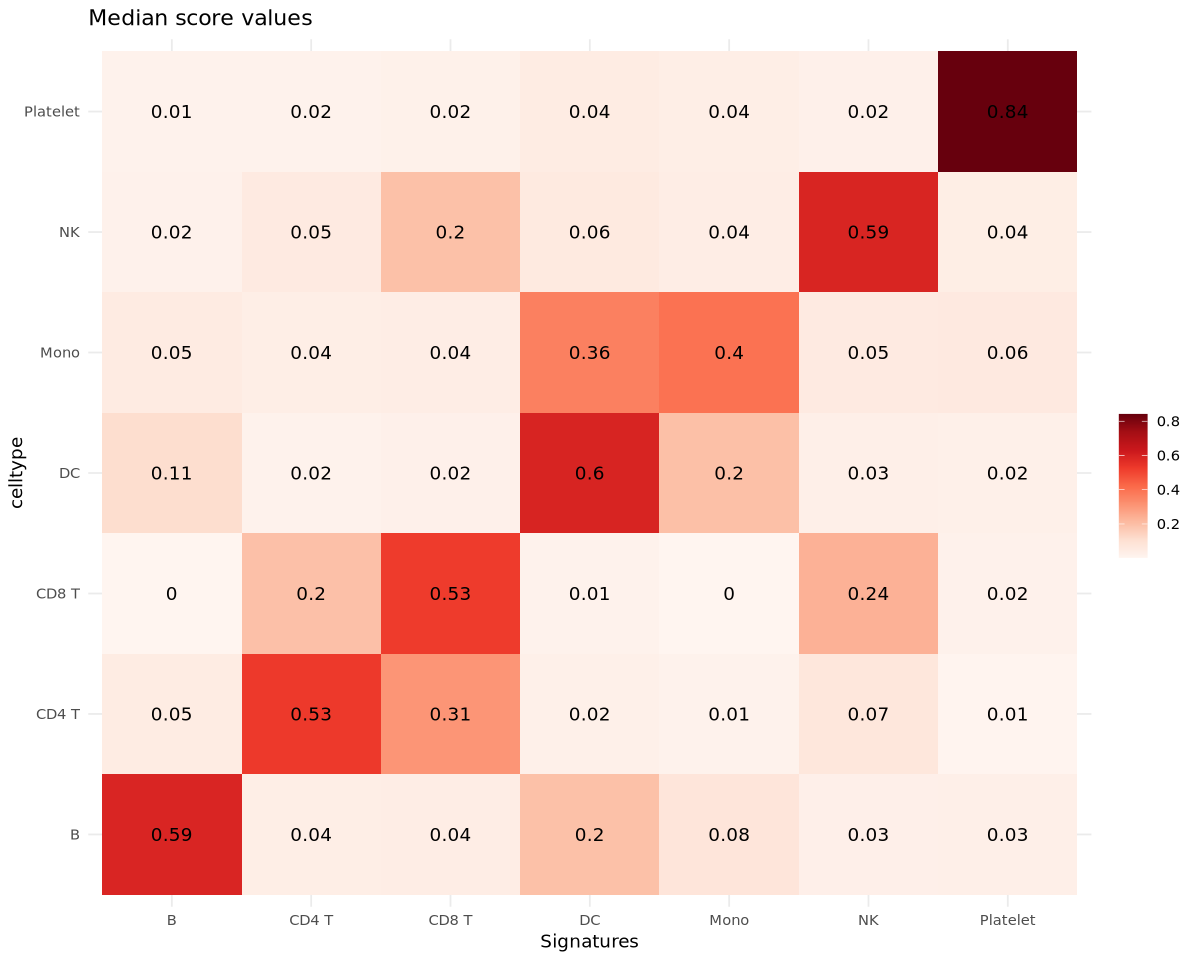

In [18]:
options(repr.plot.width=10,repr.plot.height=8)
grouped_distributions(SO@meta.data, ref_obs='celltype', columns_obs = names(gmt), scale_medians = 'column-wise')

The statistical tests confirmed that the **visible differences in signature score distributions are significant**, indicating that scaled signature scores are consistent with authors annotation. 
With the evidence of the goodness of the signatures, we proceeded with the classification of PBMC3K.

### Default classification

To classify the PBMC3K dataset we used `CIA_classify`, which directly computes and compares scaled scores of each signature in each single cell of the dataset.

In [19]:
SO<- CIA_classify(data=SO, signatures_input='../inst/extdata/atlas.gmt', 
             similarity_threshold=0, column_name= 'CIA_default', n_cpus=32)

Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132


Classification complete!    Start:19:05:53    End:19:05:55


CIA_defaulthas been added in data@meta.data




Classification is performed by **assigning to each cell the label of the signature that has the maximum scaled score value**. Because it is based on matrix and vector operations, and given the possibility to parallelize the computation, this process is **very fast**.

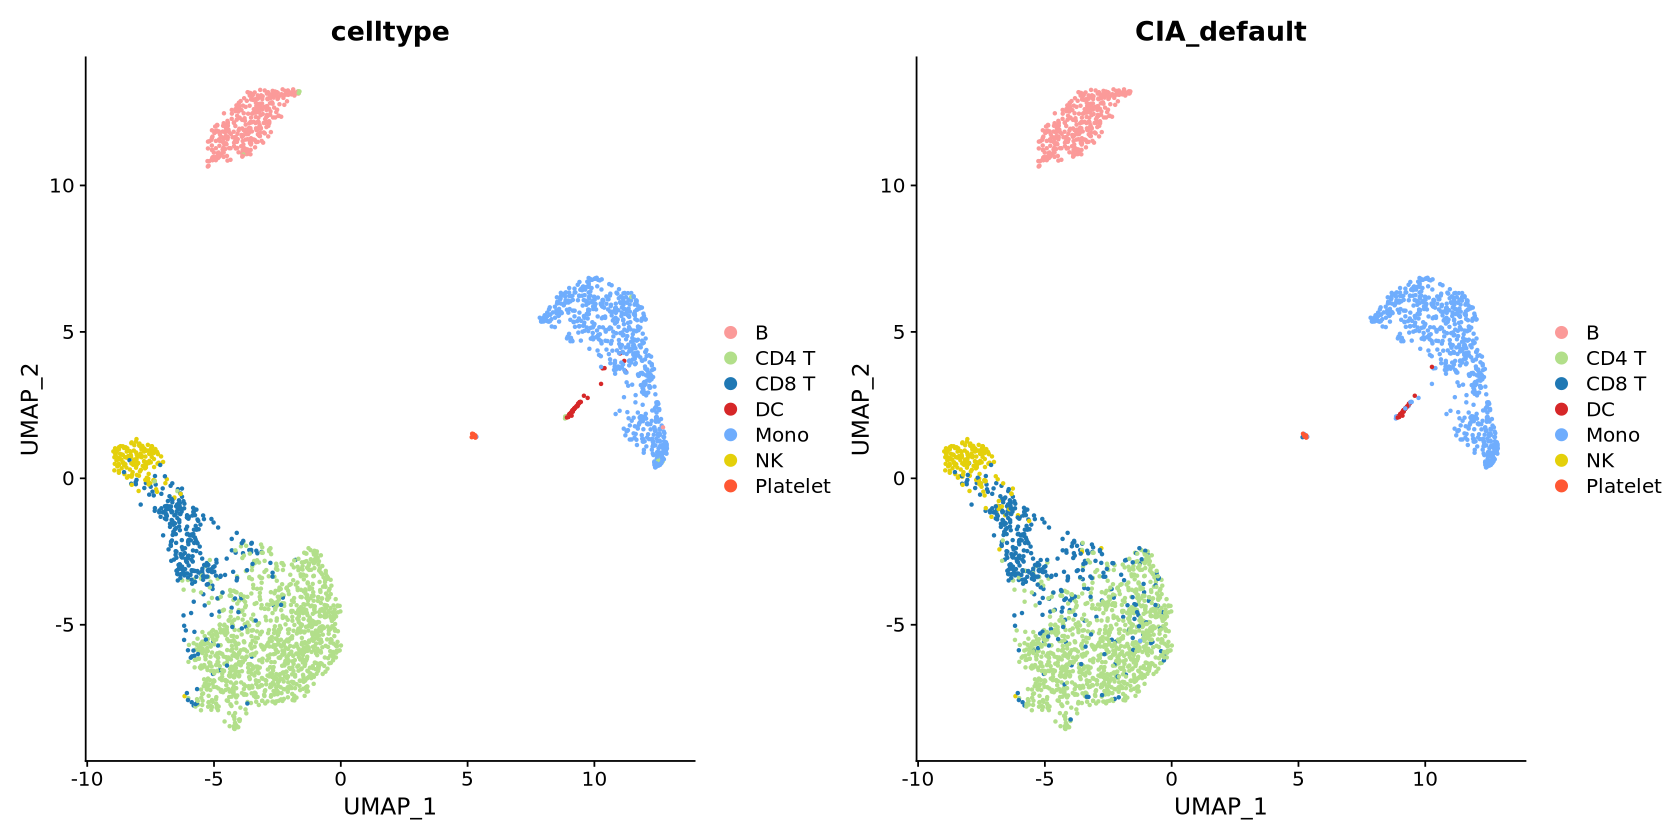

In [20]:
options(repr.plot.width=14, repr.plot.height=7)
cols<- c('#fb9a99','#b2df8a', '#1f78b4','#d62728', '#6fadfd','#E4D00A','#FF5733')
DimPlot(SO, group.by = 'celltype', cols=cols)|DimPlot(SO, group.by = 'CIA_default' , cols=cols )

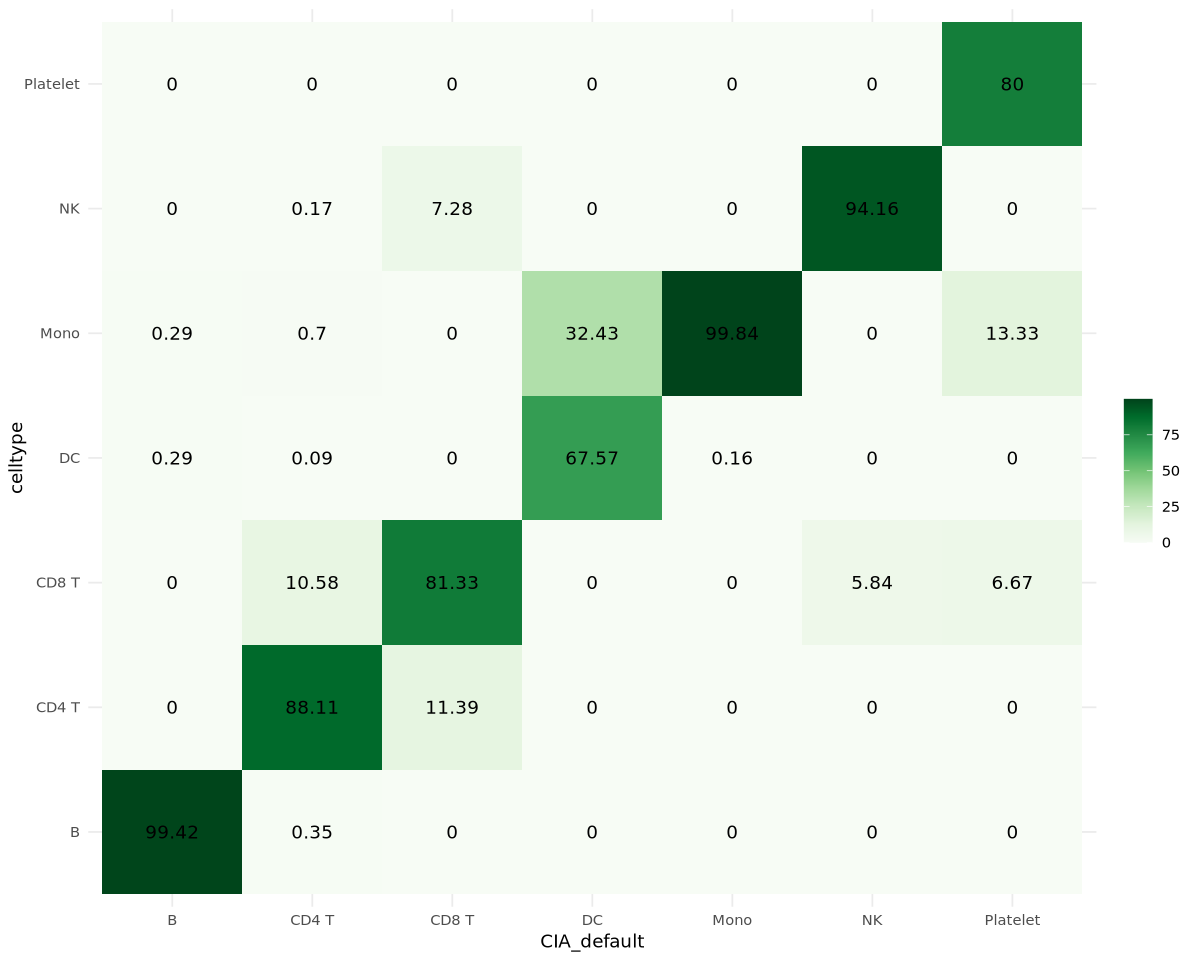

In [21]:
options(repr.plot.width=10,repr.plot.height=8)
group_composition(SO@meta.data, classification_obs = 'CIA_default', ref_obs = 'celltype')

The confusion matrix reveals that the classification method is highly effective, with most cells being correctly labeled according to their true cell types. The errors that did occur are relatively few and can be summarized as follows:

- **CD4 T cells:** Predominantly classified correctly, with a small number misclassified as CD8 T cells.
- **CD8 T cells:** Mostly identified accurately, but with some confusion with NK cells noted.
- **Dendritic cells:** Generally well-classified, although there is a tendency for some cells to be mislabeled as monocytes.

### Classification with similarity threshold

The similarity threshold is a critical parameter in the classification process, utilized within the `CIA_classify` function. It sets **the minimum required difference between the highest and second-highest signature scores** for a cell to be confidently classified into a specific category. This threshold **prevents ambiguous classifications** and ensures that cells are distinctly assigned to the most appropriate categories based on their signature expression levels.

Cells whose signature scores do not meet this threshold are labeled as **'Unassignned'**. This label indicates that these cells do not exhibit a strong correlation with any of the predefined signatures, thus avoiding misclassification.

Here we test 3 tresholds: 5%, 10% and 15%.

In [22]:
for (t in c(0.05,0.1,0.15)){
SO<- CIA_classify(data=SO, signatures_input='../inst/extdata/atlas.gmt', unassigned_label = 'Unassigned',
             similarity_threshold=t, column_name= paste0('CIA_t', as.character(t)), n_cpus=32)
    }

Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132


Classification complete!    Start:19:05:56    End:19:05:57


CIA_t0.05has been added in data@meta.data


Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132


Classification complete!    Start:19:05:57    End:19:05:58


CIA_t0.1has been added in data@meta.data


Checking if genes are in the dataset matrix...


B: 101 / 115

CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132


Classification complete!    Start:19:05:58    End:19:06:00


CIA_t0.15has been added in data@meta.data




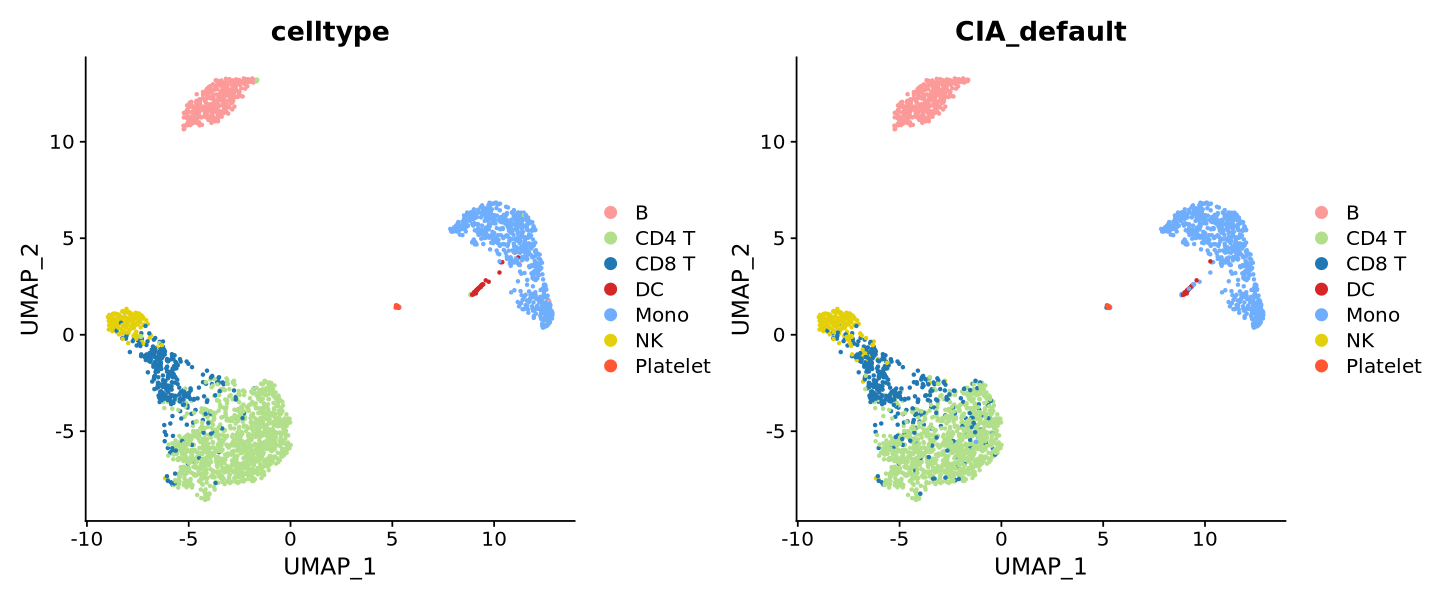

In [23]:
options(repr.plot.width=12, repr.plot.height=5)
cols<- c('#fb9a99','#b2df8a', '#1f78b4','#d62728', '#6fadfd','#E4D00A','#FF5733')
DimPlot(SO, group.by = 'celltype', cols=cols)|DimPlot(SO, group.by = 'CIA_default' , cols=cols )

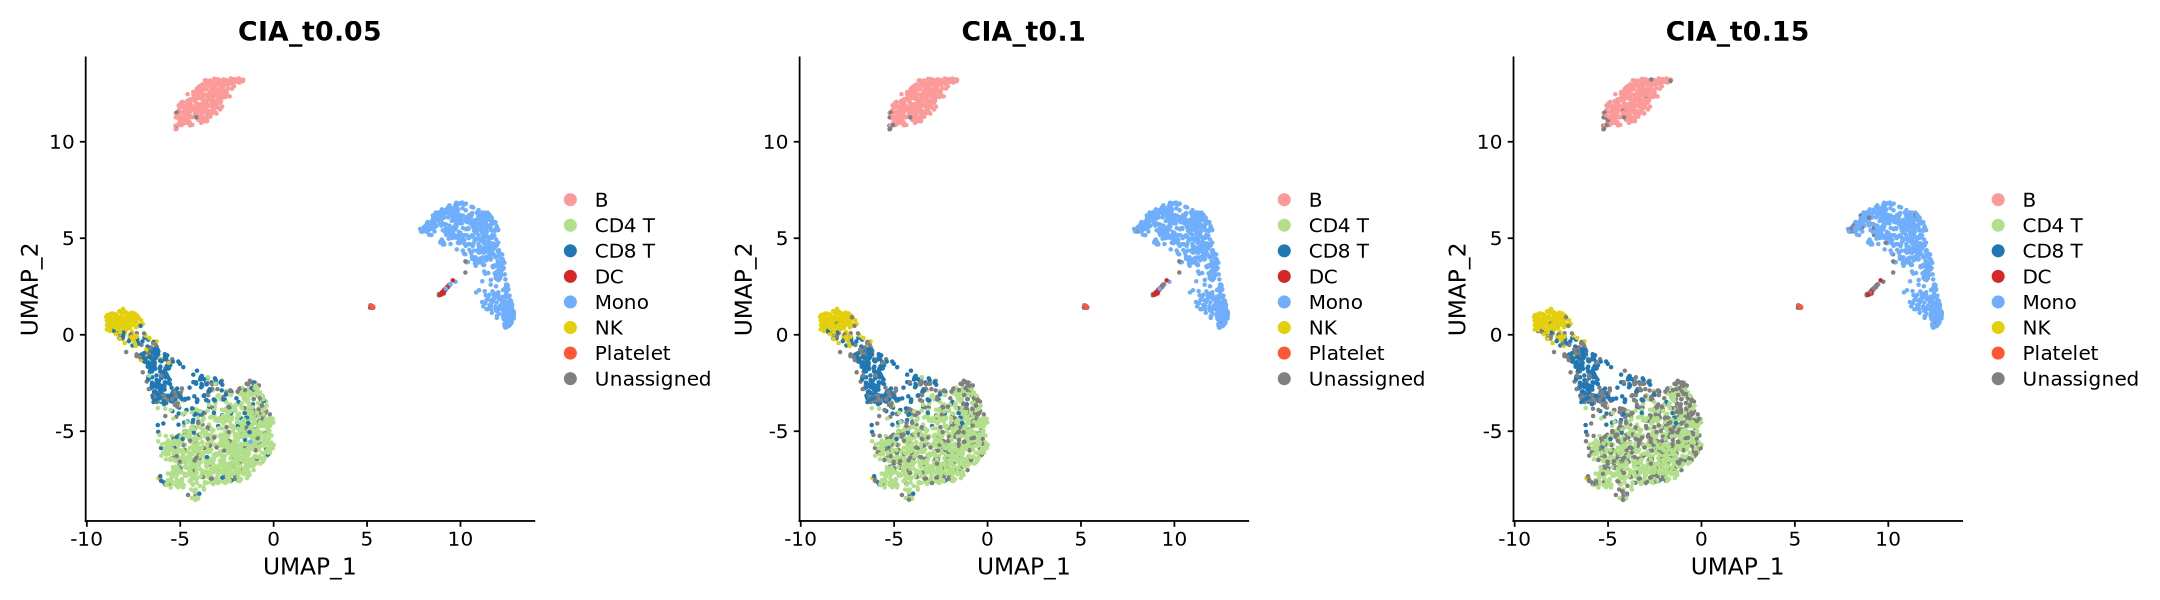

In [24]:
options(repr.plot.width=18, repr.plot.height=5)
cols<- c('#fb9a99','#b2df8a', '#1f78b4','#d62728', '#6fadfd','#E4D00A','#FF5733', '#808080')
DimPlot(SO, group.by = 'CIA_t0.05', cols=cols)|DimPlot(SO, group.by = 'CIA_t0.1' , cols=cols )|
DimPlot(SO, group.by = 'CIA_t0.15' , cols=cols )

Raising the similarity threshold in the classification algorithm indeed leads to a greater number of cells being labeled as **"Unassigned"**. This change typically affects **cells that previously might have been incorrectly classified**, particularly those within groups that exhibit closely related signature profiles. As the similarity threshold increases, the classifier becomes more conservative, requiring a higher degree of confidence before assigning a label. Consequently, **cells that do not distinctly match a particular signature according to the stricter criteria are more likely to remain unclassified**.

To further show the importance of this threshold we removed a signature from the dictionary in order to simulate the situation in which a cell type of the dataset is not represented by the signatures.

In [25]:
gmt$B <- NULL

In [26]:
for (t in c(0,0.1)){
SO<- CIA_classify(data=SO, signatures_input=gmt, unassigned_label = 'Unassigned',
             similarity_threshold=t, column_name= paste0('CIA_noB_t', as.character(t)), n_cpus=32)
    }

Checking if genes are in the dataset matrix...


CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132


Classification complete!    Start:19:06:01    End:19:06:02


CIA_noB_t0has been added in data@meta.data


Checking if genes are in the dataset matrix...


CD4 T: 40 / 43

CD8 T: 20 / 22

DC: 151 / 156

Mono: 649 / 674

NK: 126 / 130

Platelet: 123 / 132


Classification complete!    Start:19:06:02    End:19:06:04


CIA_noB_t0.1has been added in data@meta.data




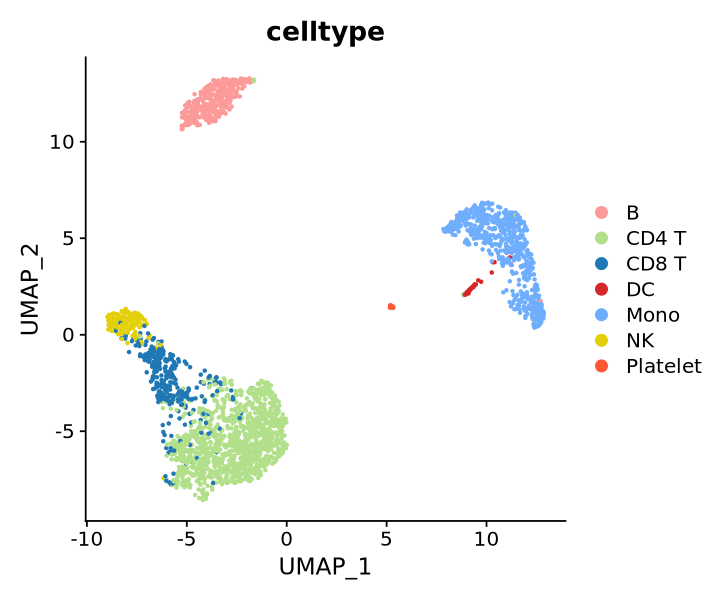

In [27]:
options(repr.plot.width=6, repr.plot.height=5)
cols<- c('#fb9a99','#b2df8a', '#1f78b4','#d62728', '#6fadfd','#E4D00A','#FF5733')
DimPlot(SO, group.by = 'celltype', cols=cols)

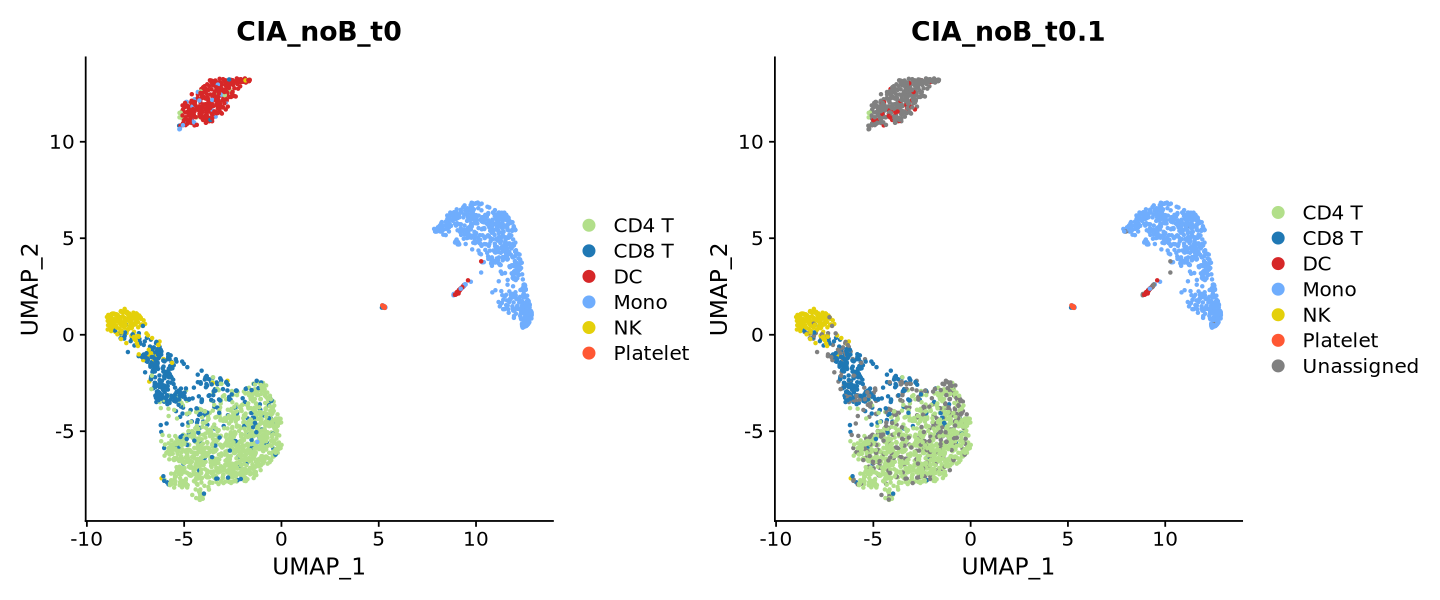

In [28]:
options(repr.plot.width=12, repr.plot.height=5)
cols<- c('#b2df8a', '#1f78b4','#d62728', '#6fadfd','#E4D00A','#FF5733', '#808080')
DimPlot(SO, group.by = 'CIA_noB_t0', cols=cols)|DimPlot(SO, group.by = 'CIA_noB_t0.1' , cols=cols )

Indeed, applying a similarity threshold has proven to be a **crucial step for enhancing the specificity and reliability of the classification results**. It has effectively reduced the mislabeling of B cells as Dendritic Cells (DC), demonstrating its value in refining the accuracy of cell type predictions. Moreover, the threshold's role in identifying 'Unassigned' cells **helps flag potential new or unexpected cell types**, such as contaminants or previously unidentified cell populations, within the sample. This feature is especially beneficial for exploratory analyses where novel discoveries are a possibility.

## Classification performance evaluation

To evaluate classification performances both per ground truth cluster and overall we exploited respectively `grouped_classification_metrics` and `compute_classification_metrics` functions.  

In both functions **cell labels assigned by CIA and the annotation already present in test datasets are compared** in order to count true positive (TP), true negative (TN), false positive (FP) and false negative (FN) cells for each cluster. 
Only for the overall calculation the per-cluster counts are summed to obtain the total TN, TP, FN and FP.

Then, again for both functions, the following metrics are calculated:
- **Sensitivity** (SE)= TP/(TP+FN)
- **Specificity** (SP)= TN/(TN+FP)
- **Precision** (PR)= TP/(TP+FP)
- **Accuracy** (ACC)= (TN+TP)/(TN+TP+FN+FP)
- **F1-score** (F1)= 2*TP/(2*TP+FN+FP)


N.B.: the column of the classification of interest and the one with ground truth labels must have the same categories to be compared.

Here, for clarity, we show only the **per-cluster classification** metrics of a single classification.

In [29]:
grouped_classification_metrics(SO@meta.data, classification_col = 'CIA_default', ref_labels = 'celltype')

,SE,SP,PR,ACC,F1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD4 T,0.8811189,0.9759036,0.9655172,0.9347991,0.9213894
B,0.9941520,0.9982578,0.9883721,0.9977255,0.9912536
Mono,0.9984127,0.9885458,0.9647239,0.9909022,0.9812793
NK,0.9415584,0.9899356,0.8529412,0.9871114,0.8950617
CD8 T,0.8132911,0.9435831,0.6623711,0.9279757,0.7301136
DC,0.6756757,0.9988466,0.8928571,0.9943139,0.7692308
Platelet,0.8000000,1.0000000,1.0000000,0.9988628,0.8888889


And here are reported the **overall perfomances of each classification modality**:

In [30]:
cols <- c('CIA_default','CIA_t0.05','CIA_t0.1','CIA_t0.15','CIA_noB_t0','CIA_noB_t0.1')
compute_classification_metrics(SO@meta.data, classification_cols = cols, ref_labels = 'celltype')

,SE,SP,PR,ACC,F1
CIA_default,0.9158453,0.9859742,0.9158453,0.9759558,0.9158453
CIA_t0.05,0.8711145,0.9900809,0.9360489,0.9730857,0.9024151
CIA_t0.1,0.8032600,0.9932398,0.9519317,0.9660999,0.8712993
CIA_t0.15,0.7361638,0.9949457,0.9604352,0.9579768,0.8334764
CIA_noB_t0,0.7873389,0.9645565,0.7873389,0.9392397,0.7873389
CIA_noB_t0.1,0.6789234,0.9912181,0.9279793,0.9466046,0.7841506


As the similarity threshold is raised, **overall classification performance may decrease due to an increase in the number of 'Unassigned' cells**, which are counted as misclassified. However, **by setting the unassigned_label, we can exclude 'Unassigned' cells from performance metrics calculations**, thereby refining our analysis. Consequently, a new column indicating the percentage of unlabeled cells will be included in the output, providing additional insight into the classification process.

In [31]:
compute_classification_metrics(SO@meta.data, classification_cols = cols, ref_labels = 'celltype',
                               unassigned_label = 'Unassigned')

,SE,SP,PR,ACC,F1,%UN
CIA_default,0.9158453,0.9859742,0.9158453,0.9759558,0.9158453,0.00
CIA_t0.05,0.9360489,0.9893415,0.9360489,0.9817283,0.9360489,6.94
CIA_t0.1,0.9519317,0.9919886,0.9519317,0.9862662,0.9519317,15.62
CIA_t0.15,0.9604352,0.9934059,0.9604352,0.9886958,0.9604352,23.35
CIA_noB_t0,0.7873389,0.9645565,0.7873389,0.9392397,0.7873389,0.00
CIA_noB_t0.1,0.9279793,0.9879965,0.9279793,0.9794226,0.9279793,26.84


## Tips

### Direct inspection of MSigDB signatures

With the `score_signature` and `score_all_signatures` functions, you can compute and inspect signatures from the [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb/) by simply providing the corresponding URL.

In [32]:
head(score_signature(SO, 
                     geneset = 'https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=GOBP_PHAGOCYTOSIS&fileType=gmt'))

[1] 0 0 0 0 0 0

In [33]:
SO <- score_all_signatures(SO, score_mode = 'scaled',
                     signatures_input = 'https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=GOBP_PHAGOCYTOSIS&fileType=gmt')

Warning message in readLines(signatures_input):
“incomplete final line found on 'https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=GOBP_PHAGOCYTOSIS&fileType=gmt'”
Checking if genes are in the dataset matrix...


GOBP_PHAGOCYTOSIS: 175 / 237

Scores have been added in data@meta.data




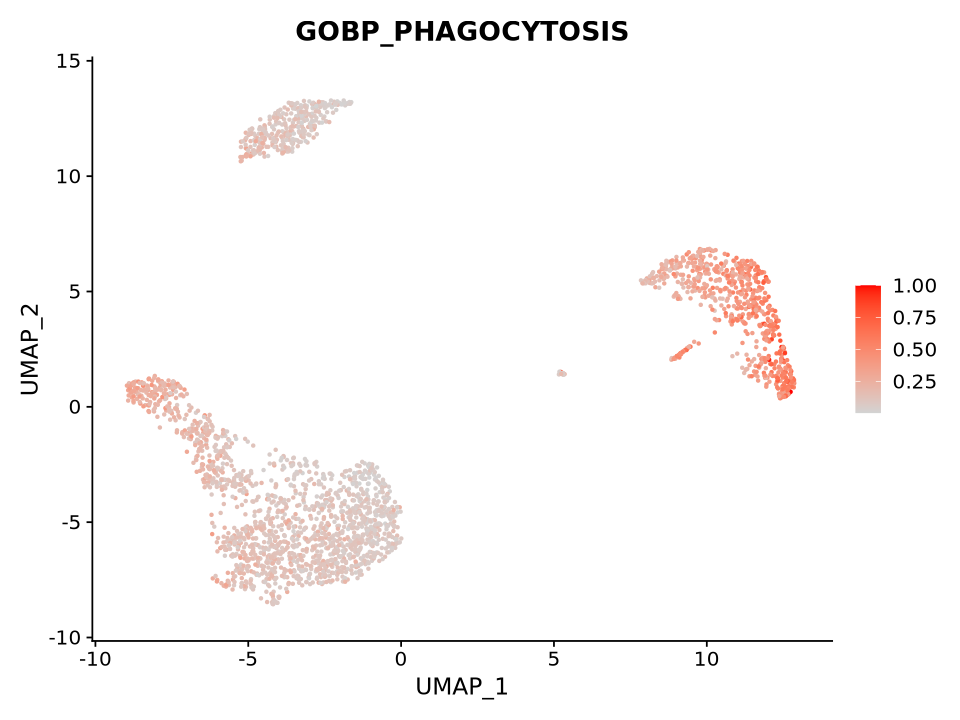

In [34]:
options(repr.plot.width=8,repr.plot.height=6)
FeaturePlot(object = SO, features = 'GOBP_PHAGOCYTOSIS', cols = c("lightgrey", "red"))

### Majority voting

The **Celltypist** classifier [[4]](https://www.science.org/doi/10.1126/science.abl5197) features an intriguing process called **'majority voting,'** which refines cell identities within subclusters following an **over-clustering step**. In essence, **within each subcluster**, the **label of the predominant cell type is applied** to all cells in that group. While this step extends beyond the standard CIA workflow, we aimed to compare classification results under optimal conditions. To this end, we developed the `celltypist_majority_vote` function (**external module**) to emulate the 'majority voting' mechanism.

N.B.: Due to a different implementation of the Leiden algorithm, results may be slightly different from the Python version of CIA.

In [35]:
SO <-celltypist_majority_vote(SO, classification_obs = c('CIA_default', 'CIA_t0.1'))

Reference annotation not selected. Computing over-clustering with Leiden algorithm

Dataset has been divided into 87 groups according to transcriptional similarities.

Over-clustering result saved in metadata as overclustering

Extending the more represented cell type label to each cell group...


New classification labels have been stored in metadata as CIA_default_majority_voting.

New classification labels have been stored in metadata as CIA_t0.1_majority_voting.



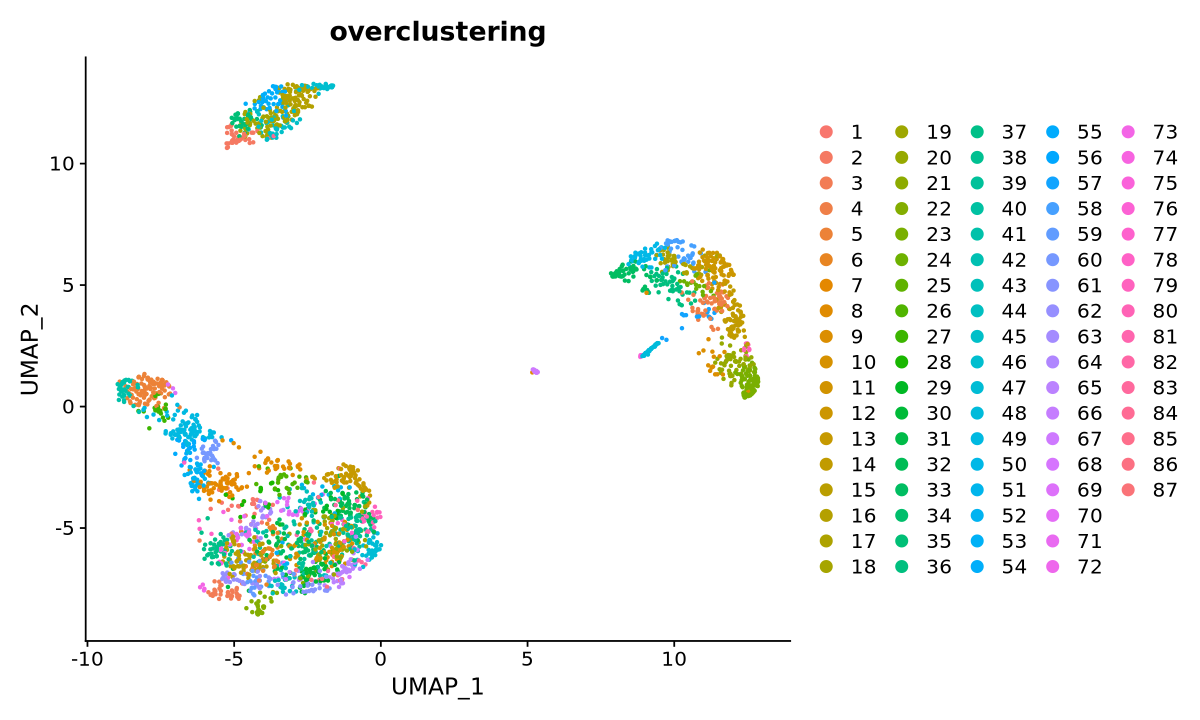

In [36]:
options(repr.plot.width=10, repr.plot.height=6)
DimPlot(SO, group.by = 'overclustering')

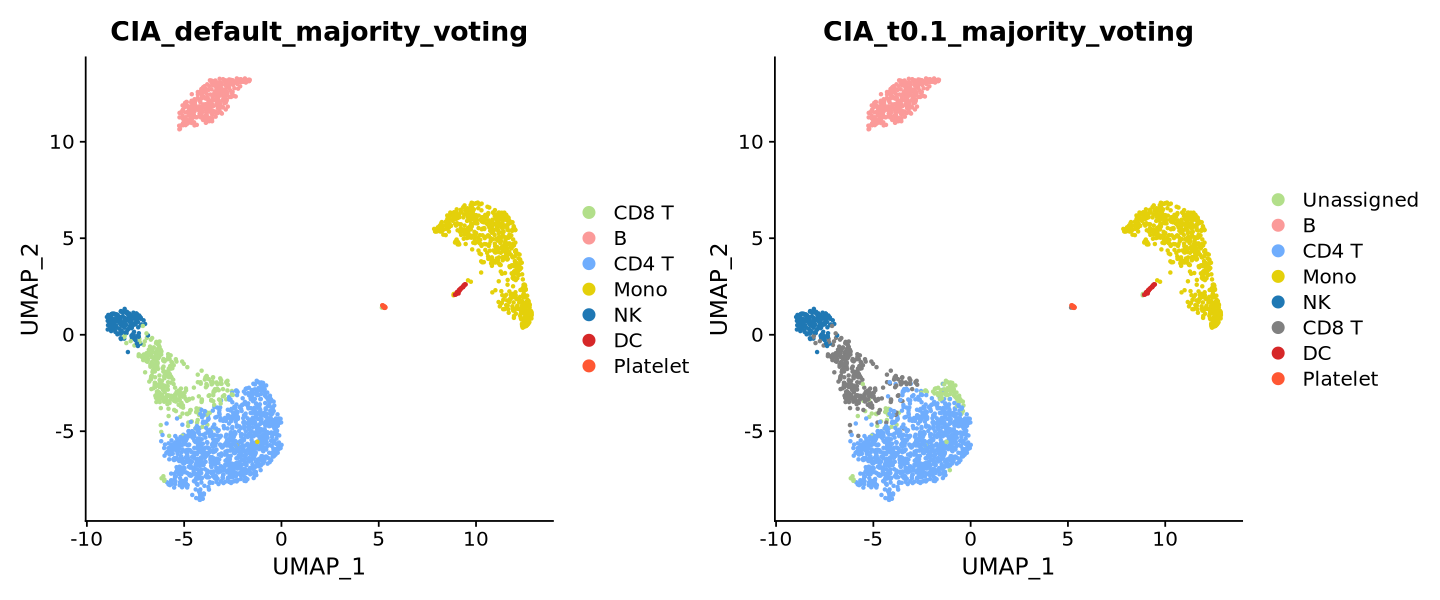

In [37]:
options(repr.plot.width=12, repr.plot.height=5)
cols1<- c('#b2df8a','#fb9a99', '#6fadfd', '#E4D00A','#1f78b4','#d62728','#FF5733')
cols2<- c('#b2df8a','#fb9a99', '#6fadfd', '#E4D00A','#1f78b4', '#808080','#d62728','#FF5733')
DimPlot(SO, group.by = 'CIA_default_majority_voting', cols = cols1) | DimPlot(SO, group.by = 'CIA_t0.1_majority_voting', cols = cols2)

In [38]:
cols <- c('CIA_default_majority_voting','CIA_t0.1_majority_voting')
compute_classification_metrics(SO@meta.data, classification_cols = cols, ref_labels = 'celltype', unassigned_label = 'Unassigned')

,SE,SP,PR,ACC,F1,%UN
CIA_default_majority_voting,0.9389689,0.9898282,0.9389689,0.9825625,0.9389689,0.00
CIA_t0.1_majority_voting,0.9531312,0.9921885,0.9531312,0.9866089,0.9531312,3.75


### Extraction of signatures from Differentially Expressed Genes

With Seurat, it is possible to extract signatures for use with CIA to classify other datasets in few steps:

In [39]:
Idents(SO)<- SO@meta.data$celltype
pbmc_degs <- FindAllMarkers(SO, logfc.threshold = 0.5, min.pct = 0.3, only.pos = T)
pbmc_degs<- pbmc_degs[pbmc_degs$p_val < 0.01,]
pbmc_gmt <- list()

for (i in unique(pbmc_degs$cluster)){
    pbmc_gmt[[i]]<- pbmc_degs[pbmc_degs$cluster==i, 'gene']
    
    cat(paste0(i, ':'), length(pbmc_gmt[[i]]), 'genes \n')
}

Calculating cluster CD4 T

Calculating cluster B

Calculating cluster Mono

Calculating cluster NK

Calculating cluster CD8 T

Calculating cluster DC

Calculating cluster Platelet



CD4 T: 135 genes 
B: 79 genes 
Mono: 358 genes 
NK: 263 genes 
CD8 T: 93 genes 
DC: 419 genes 
Platelet: 194 genes 


### Alternative representation of cell group composition

Alternatively to the canonical confusion matrix, it is possible to visualize classification results using `plot_group_composition`. This function shows the composition of each reference group given the newly performed classification, allowing the use of the same colors used for the corresponding UMAP plot.

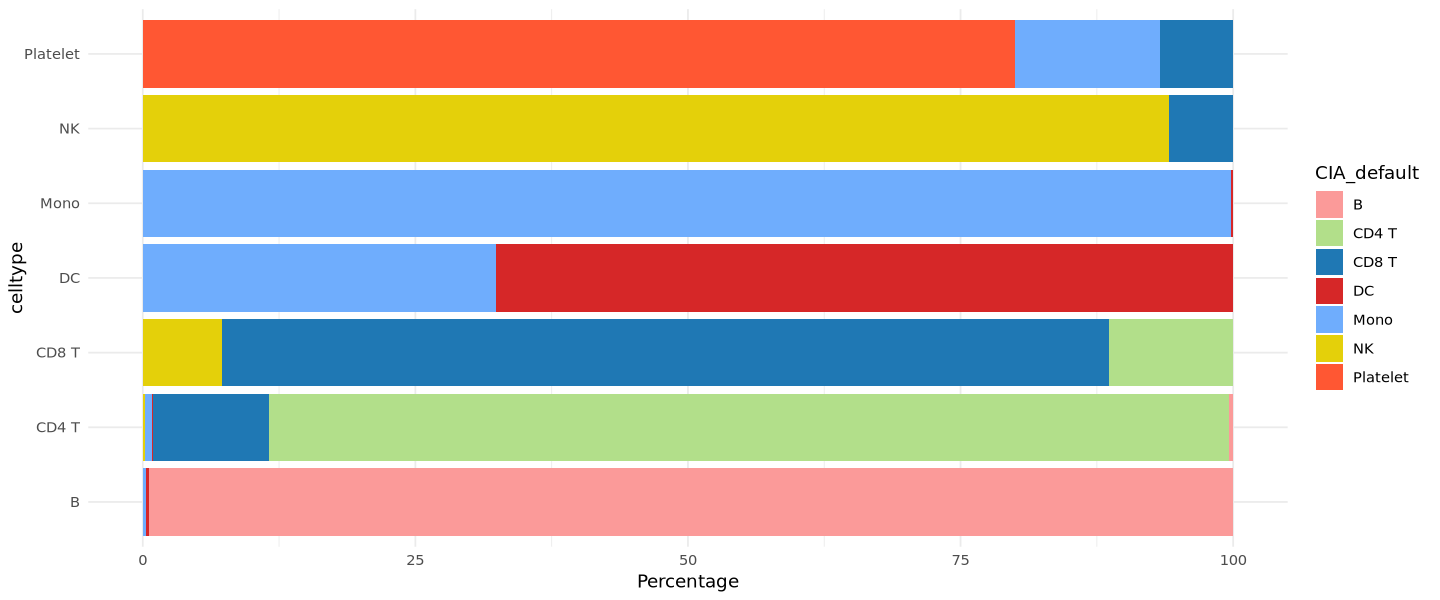

In [40]:
# Plot group composition
plot_group_composition(SO@meta.data, comp_col = "CIA_default", ref_col = "celltype",
                       palette = c('#fb9a99','#b2df8a', '#1f78b4','#d62728', '#6fadfd','#E4D00A','#FF5733'))


## Conclusion

In this notebook, we have showed the robustness and versatility of the **Cluster Independent Annotation (CIA)** method. Through the computation of signature scores and subsequent cell classification, **CIA provides a fast and efficient approach to cell type annotation in single-cell RNA sequencing data**. Additionally, we have shown that by increasing the similarity threshold, CIA can effectively mitigate misclassifications, illuminating the presence of ambiguous or novel cell types.



## References

1. Hao, Y., et al. (2021). Integrated analysis of multimodal single-cell data. *Cell*, 184(13), 3573-3587.e29. [https://www.sciencedirect.com/science/article/pii/S0092867421005833](https://www.sciencedirect.com/science/article/pii/S0092867421005833)


2. Satija, R., Farrell, J. A., Gennert, D., Schier, A. F., & Regev, A. (2015). Spatial reconstruction of single-cell gene expression data. *Nature Biotechnology*, 33, 495–502. [https://www.nature.com/articles/nbt.3192](https://www.nature.com/articles/nbt.3192)


3. Della Chiara, G., et al. (2021). Gene signature extraction and cell identity recognition at the single-cell level with Cell ID. *Nature Communications*, 12, 2262. [https://www.nature.com/articles/s41467-021-22544-y](https://www.nature.com/articles/s41467-021-22544-y)


4. Celltypist Classifier. (2022). Cell type annotation for single-cell RNA-seq data with CellTypist. *Science*, 374, eabj8222. [https://www.science.org/doi/10.1126/science.abl5197](https://www.science.org/doi/10.1126/science.abl5197)